# Homework 5

## Importing Libraries

### 1. Decision Trees as Interpretable Models

(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations


In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV

from xgboost import XGBRegressor
import xgboost as xgb

import sys
import statsmodels.api as sm

In [2]:
#Reading data
df = pd.read_csv("..\data\diagnosis.data",sep="\t",encoding="utf-16",names = ["Temperature","Nausea","Lumbar_pain","Urine_pushing","Micturition","Burning","d1","d2"],header=None)

In [3]:
df

,Temperature,Nausea,Lumbar_pain,Urine_pushing,Micturition,Burning,d1,d2
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,"41,4",no,yes,yes,no,yes,no,yes
116,"41,5",no,no,no,no,no,no,no
117,"41,5",yes,yes,no,yes,no,no,yes
118,"41,5",no,yes,yes,no,yes,no,yes


In [4]:
df.dtypes

Temperature      object
Nausea           object
Lumbar_pain      object
Urine_pushing    object
Micturition      object
Burning          object
d1               object
d2               object
dtype: object

In [5]:
def cleaning(df:pd.DataFrame):
    '''Returns cleaned dataset'''
    df["Temperature"]= df["Temperature"].str.replace(",",".")
    df["Temperature"] = df["Temperature"].astype(float)
    
    for col in ["Nausea", "Lumbar_pain", "Urine_pushing", "Micturition", "Burning","d1","d2"]:
        df[col] = df[col].replace({"no":0,"yes":1})

        
    df['class'] = np.nan
    for i in range(df.shape[0]):
        df.loc[i,'class'] = str(df.loc[i,'d1'])+str(df.loc[i,'d2'])
    
    return df

In [6]:
df = cleaning(df)
df

,Temperature,Nausea,Lumbar_pain,Urine_pushing,Micturition,Burning,d1,d2,class
0,35.5,0,1,0,0,0,0,0,00
1,35.9,0,0,1,1,1,1,0,10
2,35.9,0,1,0,0,0,0,0,00
3,36.0,0,0,1,1,1,1,0,10
4,36.0,0,1,0,0,0,0,0,00
...,...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1,01
116,41.5,0,0,0,0,0,0,0,00
117,41.5,1,1,0,1,0,0,1,01
118,41.5,0,1,1,0,1,0,1,01


#### (b) Build a decision tree on the whole data set and plot it.

The only disadvantage of Label Powerset is that as the training data increases, the number of classes also increases. With less observations and more classes, the accuracy of our model will drop.

**However in this case, we have only 4 classes: [00,10,00,11]. Thus, it seems that label powerset approach is more relavent here.**

In [7]:
X = df.drop(["d1","d2","class"],axis=1)
y = df["class"]

In [8]:
treei = DecisionTreeClassifier(criterion= "gini")
treei.fit(X,y)

DecisionTreeClassifier()

In [9]:
print("Classes:",treei.classes_)

Classes: ['00' '01' '10' '11']


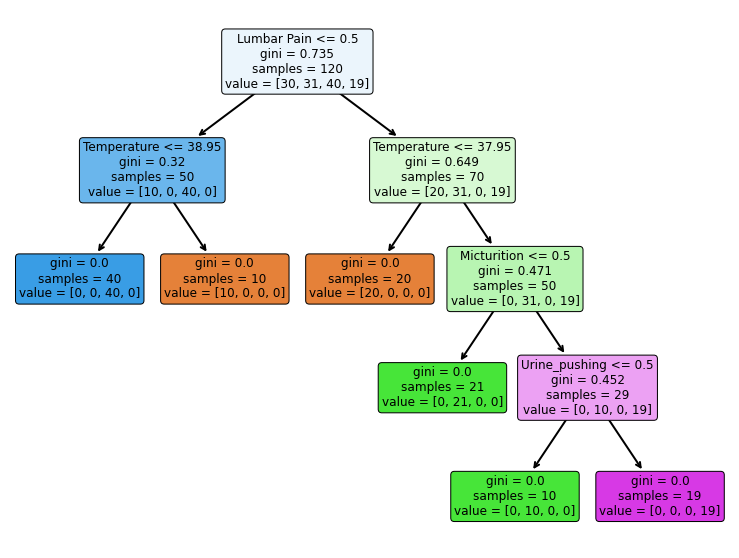

In [10]:
#Plotting the decision tree
plt.figure(figsize=(13,10))
out = plot_tree(treei,filled=True,feature_names=["Temperature","Nausea","Lumbar Pain","Urine_pushing","Micturition","Burning"],rounded=True,fontsize=12)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(2)

#### (c) Convert the decision rules into a set of IF-THEN rules.

In [11]:
def tree_to_code(tree, feature_names):
        """
        Outputs a decision tree model as a Python function. 

        Parameters:
        -----------
        tree: decision tree model
        The decision tree to represent as a function
        feature_names: list
        The feature names of the dataset used for building the decision tree
        Referenced from: https://www.kdnuggets.com/2017/05/simplifying-decision\
        -tree-interpretation-decision-rules-python.html
        """

        tree_ = tree.tree_
        feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
        ]
        print("def tree({}):".format(", ".join(feature_names)))
        print()

        def recurse(node, depth):
            indent = "  " * depth
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]
                print("{}if {} <= {}:".format(indent, name, threshold))
                recurse(tree_.children_left[node], depth + 1)
                print("{}else:  # if {} > {}".format(indent, name, threshold))
                recurse(tree_.children_right[node], depth + 1)
                print()
            else:
                print("{}return {}".format(indent, tree_.value[node]))

        recurse(0, 1)

In [12]:
tree_to_code(treei,feature_names=treei.feature_names_in_)

def tree(Temperature, Nausea, Lumbar_pain, Urine_pushing, Micturition, Burning):

  if Lumbar_pain <= 0.5:
    if Temperature <= 38.95000076293945:
      return [[ 0.  0. 40.  0.]]
    else:  # if Temperature > 38.95000076293945
      return [[10.  0.  0.  0.]]

  else:  # if Lumbar_pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Micturition <= 0.5:
        return [[ 0. 21.  0.  0.]]
      else:  # if Micturition > 0.5
        if Urine_pushing <= 0.5:
          return [[ 0. 10.  0.  0.]]
        else:  # if Urine_pushing > 0.5
          return [[ 0.  0.  0. 19.]]






#### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

Overfitting is when a model completely fits the training data and struggles or fails to generalize the testing data. This happens when the model memorizes noise in the training data and fails to pick up essential patterns which can help them with the test data.

Pruning is a technique that removes the parts of the Decision Tree which prevent it from growing to its full depth. In simpler terms, the aim of Decision Tree Pruning is to construct an algorithm that will perform worse on training data but will generalize better on test data.

**Minimal cost-complexity pruning**


**DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.**

In [13]:
treei = DecisionTreeClassifier(criterion= "gini")
path = treei.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

#Using Grid Search CV to find the best alpha
params = {'ccp_alpha': ccp_alphas}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5,scoring="accuracy")
grid_search_cv.fit(X, y)

[0.         0.09816667 0.13333333 0.182      0.22291667]
Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': array([0.        , 0.09816667, 0.13333333, 0.182     , 0.22291667])},
             scoring='accuracy', verbose=1)

In [14]:
print(grid_search_cv.best_params_)

{'ccp_alpha': 0.0}


Although best alpha is 0. Next, lets find a **set of decision rules with higher interpretability than before.**

In [15]:
results = grid_search_cv.cv_results_
res = pd.DataFrame({"alpha":results['param_ccp_alpha'],"val_acc":results['mean_test_score']})
res.sort_values(by="val_acc",ascending=False,inplace=True)

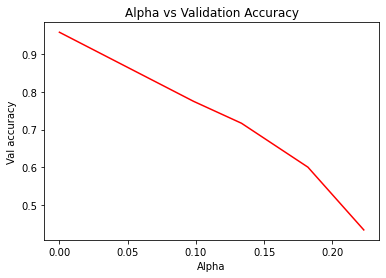

In [16]:
plt.plot(res['alpha'],res['val_acc'],'r',lw=1.5)
plt.xlabel("Alpha")
plt.ylabel("Val accuracy")
plt.title("Alpha vs Validation Accuracy")
plt.show()

In [17]:
#Using alpha at best_performance after alpha = 0, to get a tree with high interpretability
alpha_to_use = res[res['alpha']!=0]['alpha'].iloc[0]
print("Selected Alpha:",alpha_to_use)
treei = DecisionTreeClassifier(ccp_alpha=alpha_to_use)
treei.fit(X,y)

Selected Alpha: 0.09816666666666667


DecisionTreeClassifier(ccp_alpha=0.09816666666666667)

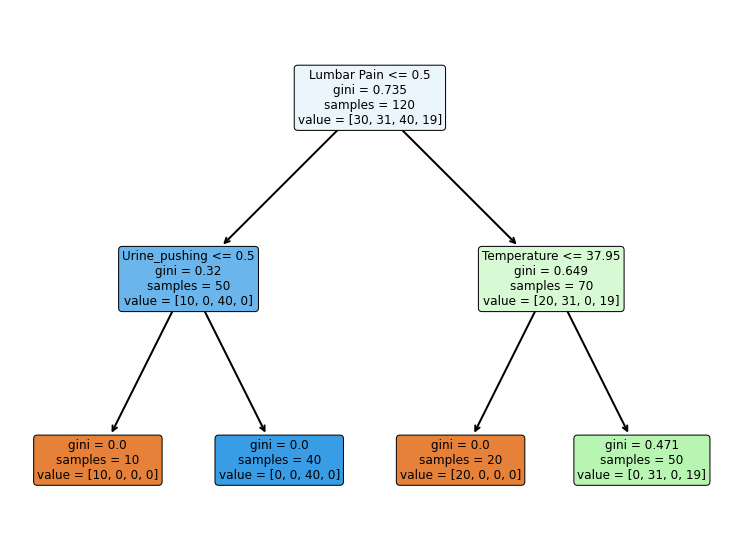

In [18]:
plt.figure(figsize=(13,10))
out = plot_tree(treei,filled=True,feature_names=["Temperature","Nausea","Lumbar Pain","Urine_pushing","Micturition","Burning"],rounded=True,fontsize=12)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(2)

In [19]:
tree_to_code(treei,feature_names=treei.feature_names_in_)

def tree(Temperature, Nausea, Lumbar_pain, Urine_pushing, Micturition, Burning):

  if Lumbar_pain <= 0.5:
    if Urine_pushing <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine_pushing > 0.5
      return [[ 0.  0. 40.  0.]]

  else:  # if Lumbar_pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      return [[ 0. 31.  0. 19.]]




### 2. The LASSO and Boosting for Regression

#### (a) Download the Communities and Crime data 3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime . Use the first 1495 rows of data as the training set and the rest as the test set.

In [20]:
names = pd.read_fwf("../data/communities.names")
idx = names[names["Title: Communities and Crime"].str.startswith("Attribute Information: (")].index
names1 = names[idx[0]:]
names1 = names1[names1["Title: Communities and Crime"].str.match(r'(^--\s+)')==True]
names1.reset_index(inplace=True)
names1.drop('index',axis=1)

community_feature_names = []
for i in names1["Title: Communities and Crime"]: community_feature_names.append(i.split(':')[0][3:])
    
df = pd.read_csv("../data/communities.data",header=None,names=community_feature_names)

# Dropping non-predictive features
df.drop(["state","county","community","communityname","fold"],axis=1,inplace=True)

# Goal
# ViolentCrimesPerPop: total number of violent crimes per 100K popuation (numeric - decimal) 

In [21]:
df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


#### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [22]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i].replace("?",np.nan,inplace=True)
        df[i] = df[i].astype(float)

In [23]:
df.shape

(1994, 123)

In [24]:
nulls = df.isnull().sum()
nulls[nulls>0]

OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64

In [27]:
imp_mean = IterativeImputer(random_state=0,max_iter=sys.maxsize)
df = imp_mean.fit_transform(df)

#If this cell takes very long to run, just import the cleaned dataframe df1

# df = pd.read_csv("imputed_df.csv").values

In [28]:
print("Shape:",df.shape)

Shape: (1994, 123)


In [29]:
#Splitting into train and test sets
train = df[:1495,:]
test = df[1495:,:]
print("Train",train.shape)
print("Test:",test.shape)

Train (1495, 123)
Test: (499, 123)


#### (c) Plot a correlation matrix for the features in the data set.

In [30]:
df1 = np.concatenate([train,test],axis=0)
df1 = pd.DataFrame(df1,columns=community_feature_names[5:])

# Saving cleaned data
# df1.to_csv("imputed_df.csv",index=None)

nulls = df1.isnull().sum()
nulls[nulls>0]

Series([], dtype: int64)

In [31]:
df1.shape

(1994, 123)

In [32]:
df1.corr()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.713652,0.231897,0.270356,0.803467,0.709977,-0.207835,0.120412,0.466352,-0.047412,0.367157
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,-0.015078,-0.004072,-0.051506,-0.127286,-0.064095,-0.101341,0.021365,-0.094368,0.018944,-0.034923
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,0.149758,0.095053,0.147023,0.245012,0.060506,-0.190324,0.107366,0.260793,-0.145613,0.631264
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.131389,-0.337458,-0.215636,-0.236066,-0.151720,0.265475,-0.216157,-0.276234,0.055761,-0.684770
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,-0.001084,0.389944,0.296921,0.016369,0.189916,-0.178947,0.187486,0.101888,0.169927,0.037622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.207835,-0.101341,-0.190324,0.265475,-0.178947,-0.113583,0.050978,-0.015141,0.042571,0.128695,...,-0.133112,-0.107826,-0.104642,-0.167640,-0.205592,1.000000,-0.058928,-0.172838,0.028745,-0.206259
LemasGangUnitDeploy,0.120412,0.021365,0.107366,-0.216157,0.187486,0.167158,0.098442,0.143929,0.091890,-0.163581,...,0.139925,-0.099591,-0.206435,0.166753,0.035585,-0.058928,1.000000,0.023524,0.086652,0.225883
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,0.299632,0.228084,0.206644,0.345127,0.202128,-0.172838,0.023524,1.000000,-0.033474,0.348627
PolicBudgPerPop,-0.047412,0.018944,-0.145613,0.055761,0.169927,0.080279,-0.127857,-0.098981,-0.103219,-0.048533,...,-0.102622,0.071379,0.052317,0.137429,0.178711,0.028745,0.086652,-0.033474,1.000000,-0.031685


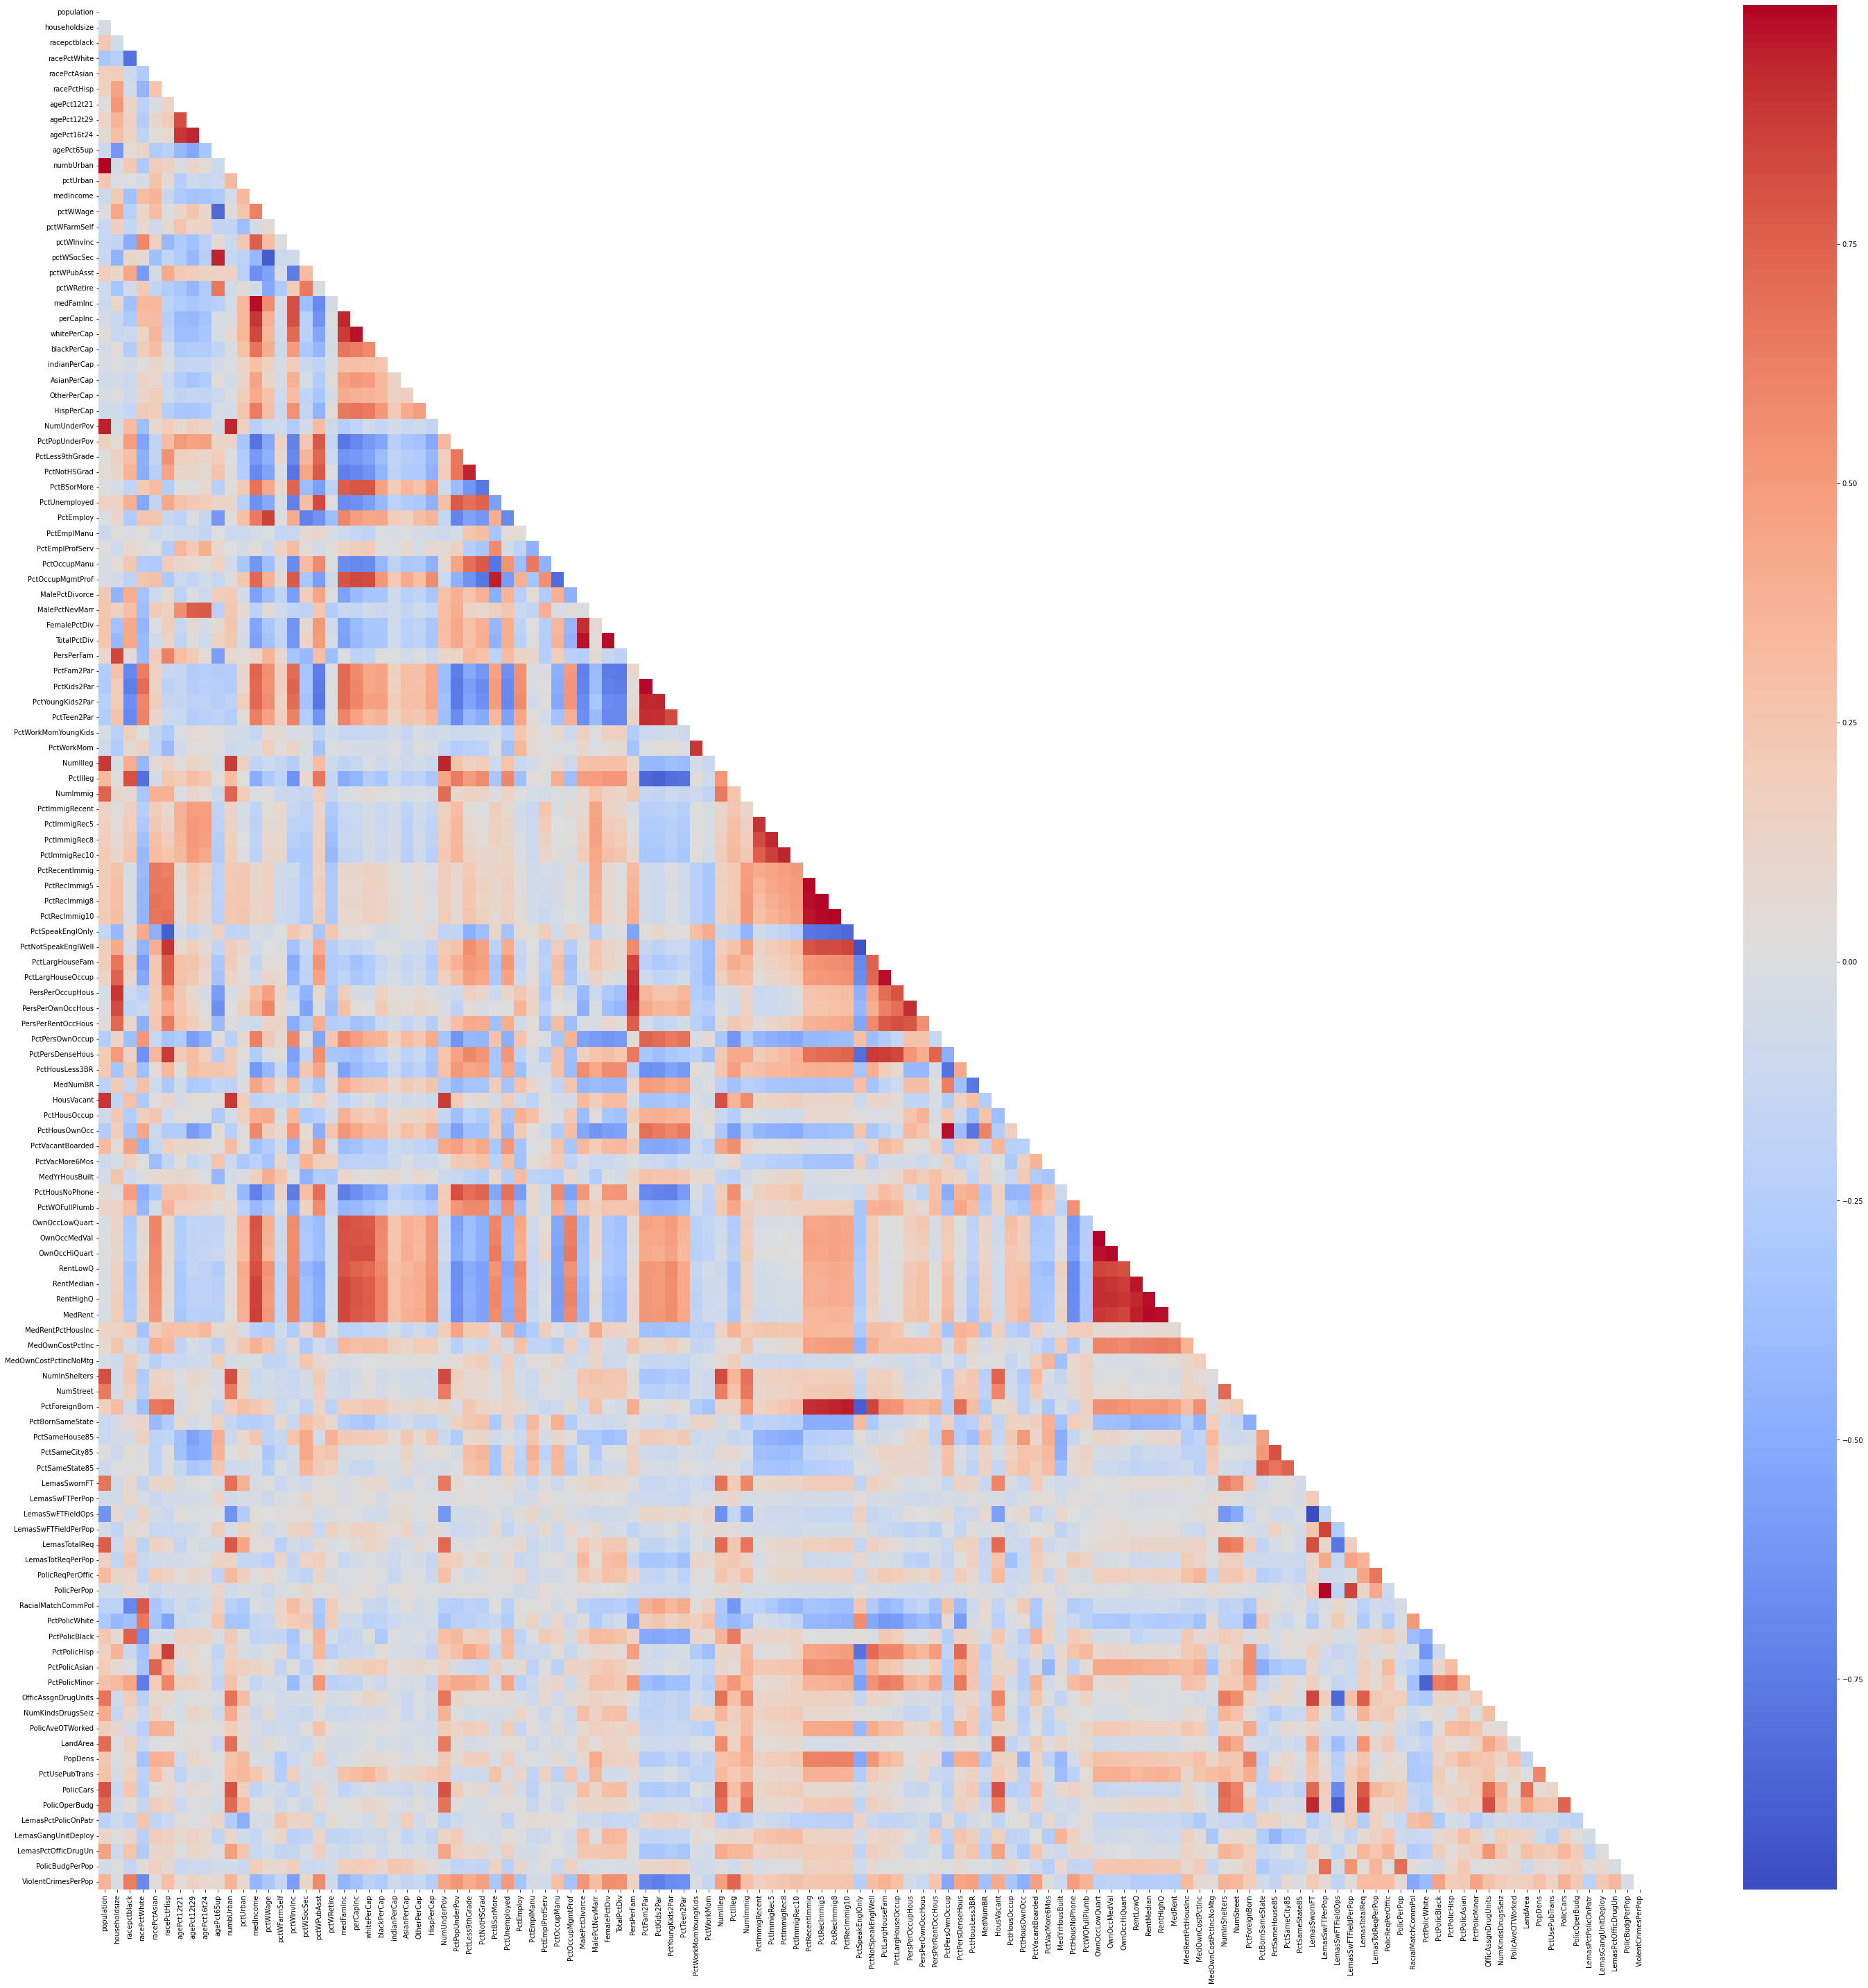

In [33]:
# Create correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(50,50))
sns.heatmap(corr,mask=mask,cmap='coolwarm')
plt.show()

#### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean. Pick floor(√ 128) features with highest CV.

A lower coefficient of variation, means it offers a better mean return relative to the standard deviation.

In [34]:
def CV(s:pd.Series):
    return (s.std(ddof=1) / s.mean()) * 100

#Storing column:CV pair
cv = {}
for col in df1.columns[:-1]:
    cv[col] = CV(df1[col])
    
n = int(np.floor(np.sqrt(128)))
cv = sorted(cv.items(),key=lambda item:item[1],reverse=True)

#Selecting features
selected_features = []
for tup in cv[:n]:
    selected_features.append(tup[0])
    
selected_features

['LemasTotalReq',
 'NumStreet',
 'NumInShelters',
 'NumIlleg',
 'LemasSwornFT',
 'NumImmig',
 'LemasPctOfficDrugUn',
 'PctPolicAsian',
 'NumUnderPov',
 'population',
 'PolicOperBudg']

#### (e) Pick floor(√ 128)  features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

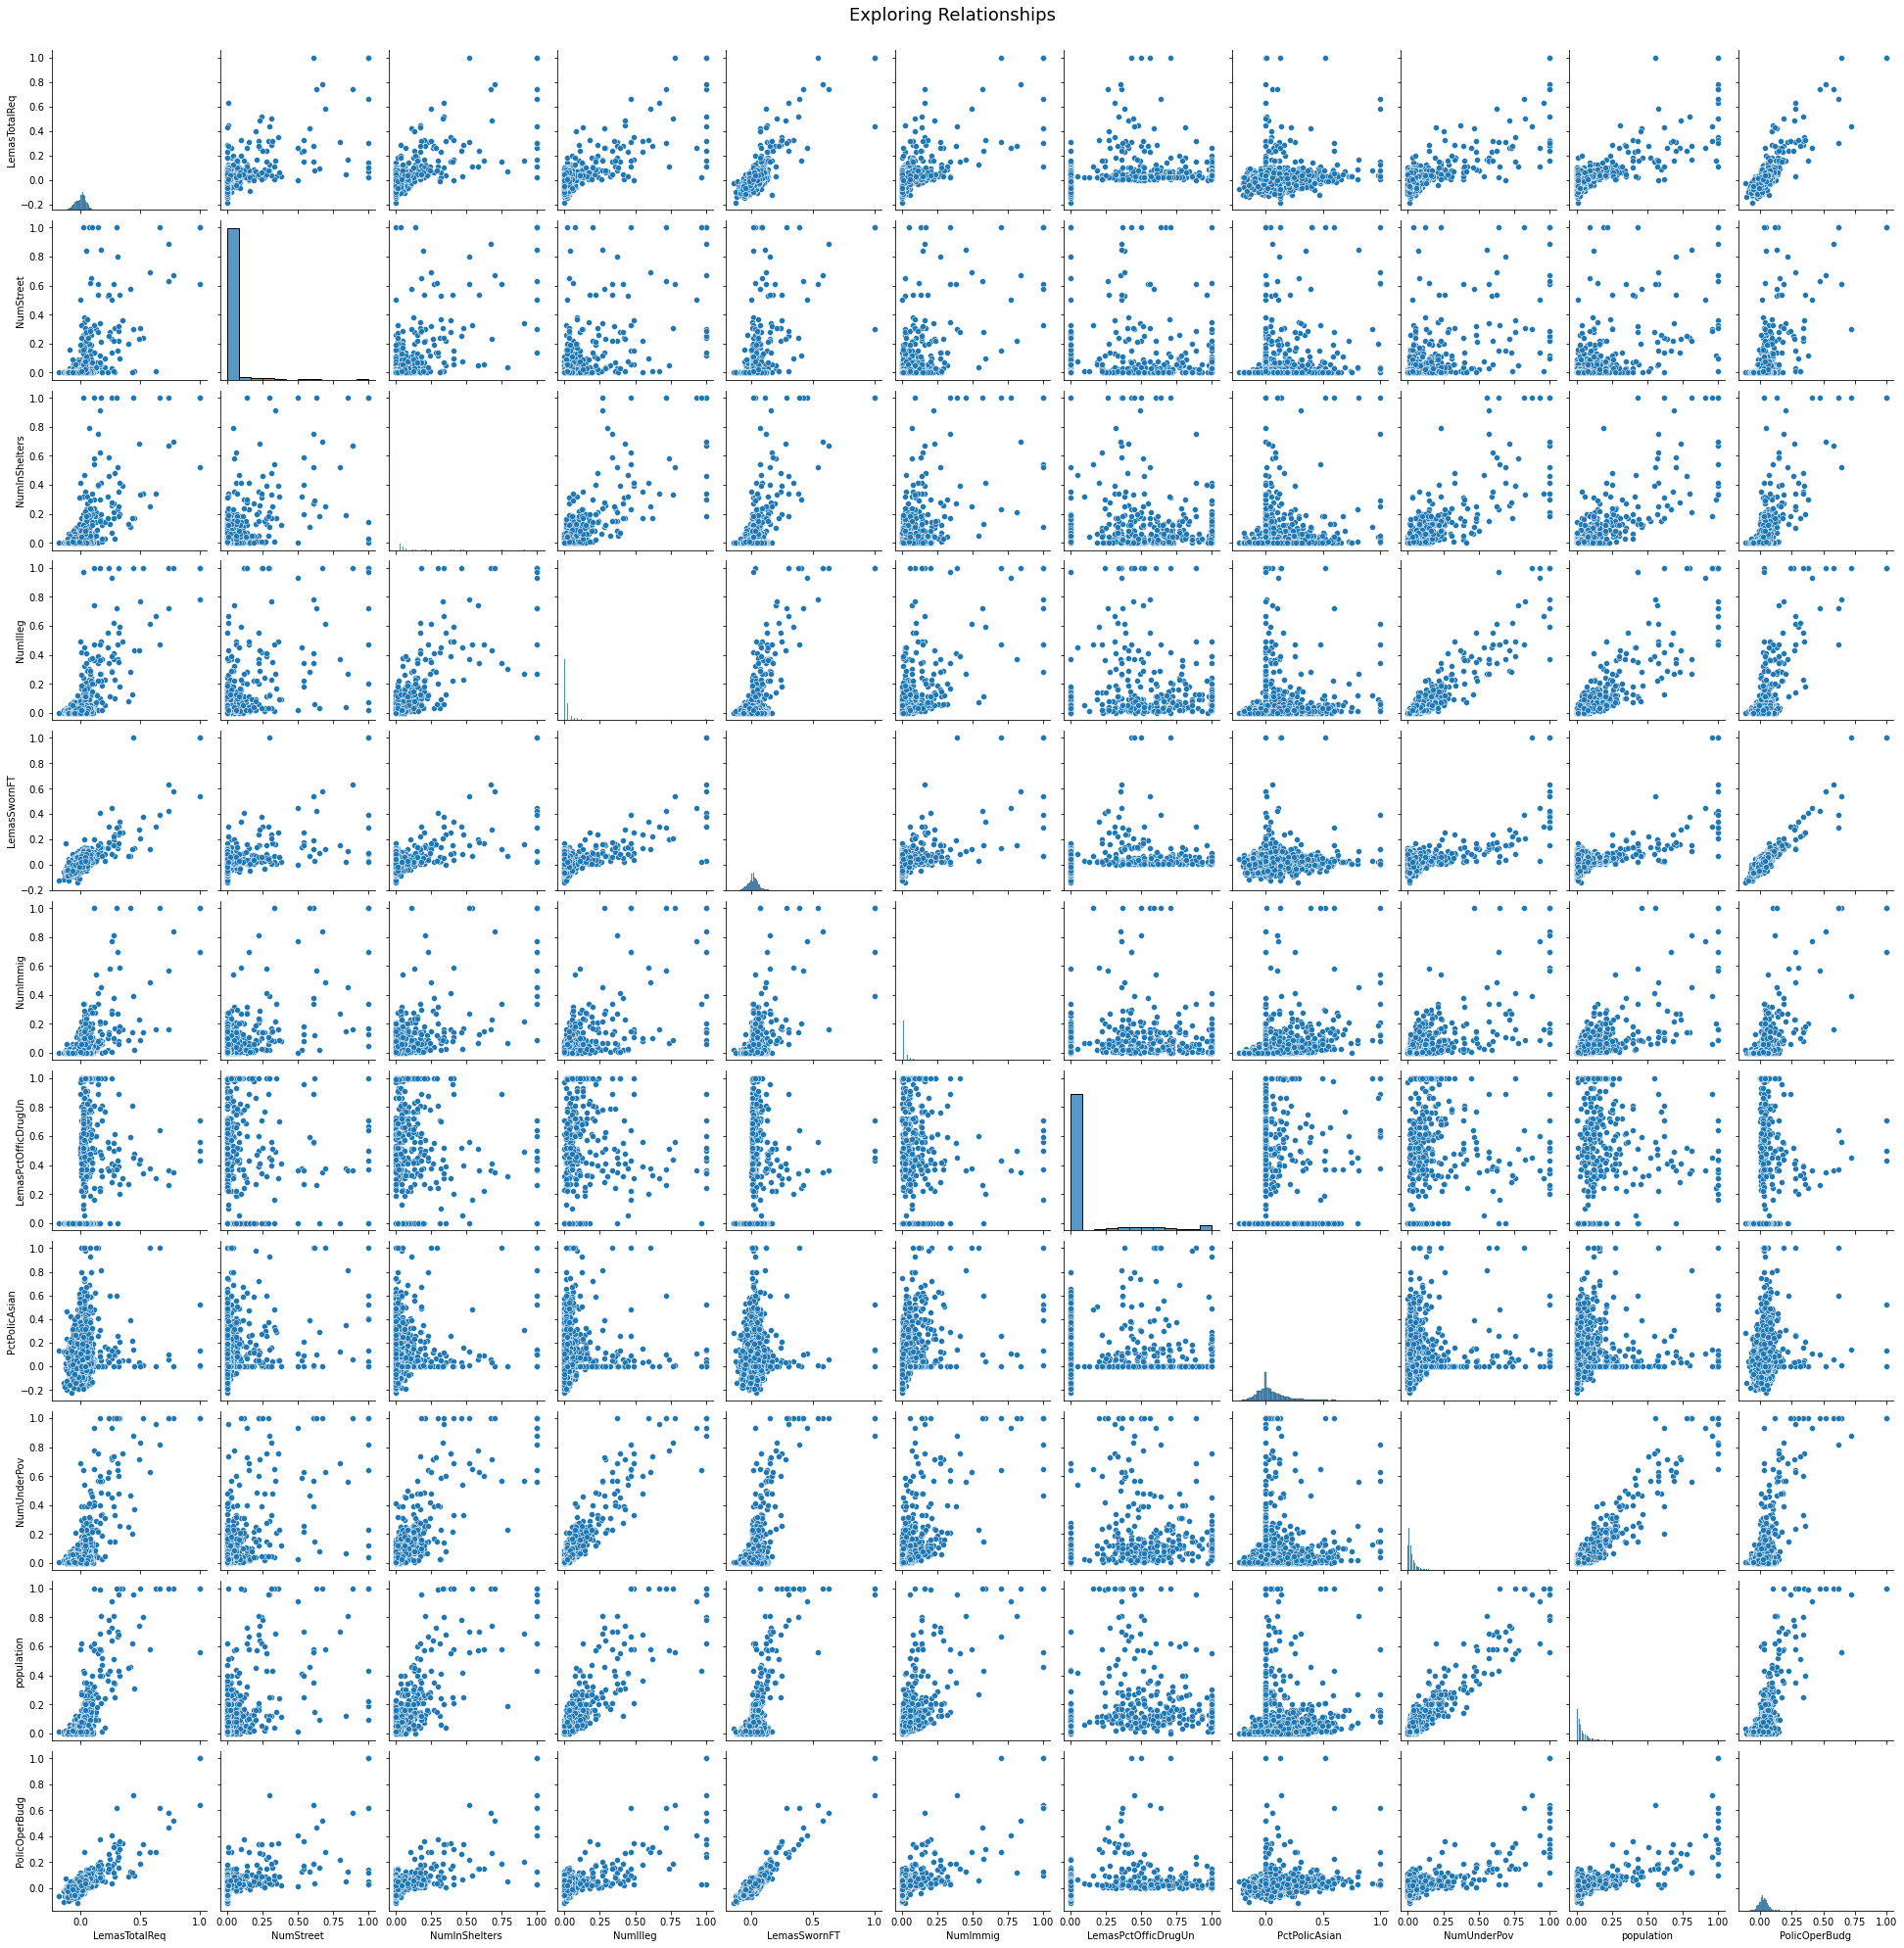

In [35]:
sns.pairplot(df1[selected_features])
plt.suptitle("Exploring Relationships",y=1.01,fontsize=18)
plt.show()

**Interpretation can be subjective. Correlation does not mean and not show causation.**

And none of the given features are correlated to goal "ViolentCrimesPerPop"

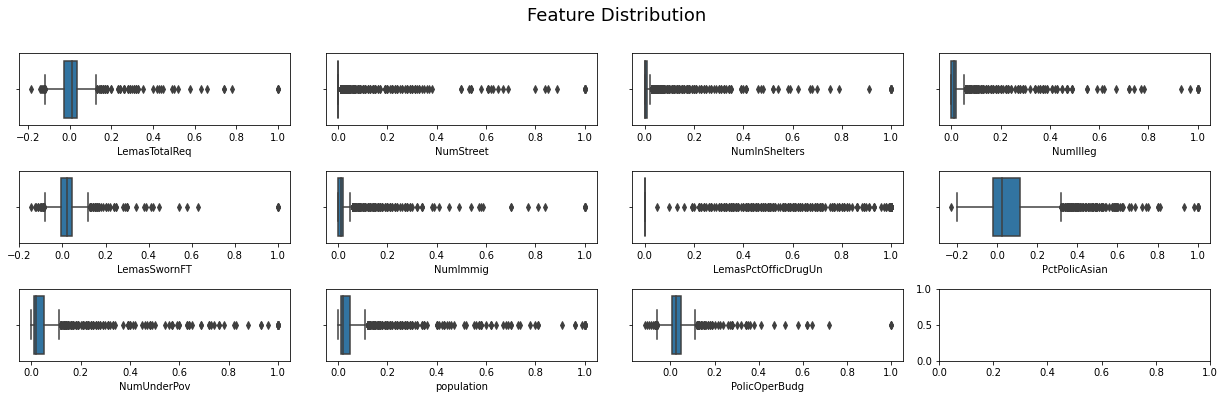

In [36]:
fig1, axes1 = plt.subplots(3,4,figsize=(17,5))
r,c = 0,0
for i in range(len(selected_features)):   
    sns.boxplot(data=df1,x=selected_features[i],ax=axes1[r][c])
    c+=1
    if c==4:
        c=0
        r+=1
fig1.tight_layout()
plt.suptitle("Feature Distribution",y=1.1,fontsize=18)
plt.show()

This features have a lot of outliers.

The **target** is included in the boxplots, it also has outliers.

In [37]:
#Getting train test sets
Xtrain = train[:,:-1]
ytrain = train[:,-1]
Xtest = test[:,:-1]
ytest = test[:,-1]

#### (f) Fit a linear model using least squares to the training set and report the test error.

In [38]:
# Ordinary Least Squares function
Xtrain1 = sm.add_constant(Xtrain)
Xtest1 = sm.add_constant(Xtest)
res = sm.OLS(ytrain,Xtrain1).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     55.69
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:22:54   Log-Likelihood:                 1360.5
No. Observations:                1495   AIC:                            -2475.
Df Residuals:                    1372   BIC:                            -1822.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8486      0.752      2.459      0.0

In [39]:
pvals = res.pvalues

#Finding significant features
idx = np.where(pvals < 0.05)
print("Number of significant features: ",idx[0].shape)

#considering significant features
Xtrain2 = Xtrain1[:,idx[0]]
Xtest2 = Xtest1[:,idx[0]]

res1 = sm.OLS(ytrain,Xtrain2).fit()

print(res1.summary())

Number of significant features:  (95,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     71.00
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:22:54   Log-Likelihood:                 1336.9
No. Observations:                1495   AIC:                            -2484.
Df Residuals:                    1400   BIC:                            -1979.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [40]:
from sklearn.metrics import mean_squared_error
print("Test MSE: ",mean_squared_error(y_true=ytest,y_pred=res1.predict(Xtest2)))

Test MSE:  0.0395759359668214


#### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [41]:
ridgecv = RidgeCV(alphas=np.arange(0.01,10,0.01),cv=5)
ridgecv.fit(Xtrain,ytrain)

RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5)

In [42]:
print("Test MSE: ",mean_squared_error(y_true=ytest,y_pred=ridgecv.predict(Xtest)))

Test MSE:  0.014765481181454517


#### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [43]:
lassocv = LassoCV(alphas=np.arange(0.01,10,0.01),cv=5)
lassocv.fit(Xtrain,ytrain)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5)

In [44]:
print("Test MSE: ",mean_squared_error(y_true=ytest,y_pred=lassocv.predict(Xtest)))

#Features Considered
features = np.array(community_feature_names[5:-1])
coefs = lassocv.coef_
print("Variables Selected by Model: ",features[np.where(coefs!=0)[0]])

Test MSE:  0.020919681104181242
Variables Selected by Model:  ['racePctWhite' 'PctKids2Par' 'PctIlleg']


In [45]:
#Using standardized features
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
Xtrain3 = s.fit_transform(Xtrain)
Xtest3 = s.transform(Xtest)

lassocv = LassoCV(alphas=np.arange(0.01,10,0.01),cv=5)
lassocv.fit(Xtrain3,ytrain)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5)

In [46]:
print("Test MSE: ",mean_squared_error(y_true=ytest,y_pred=lassocv.predict(Xtest)))

coefs = lassocv.coef_
print("\n\nVariables Selected by Model:",features[np.where(coefs!=0)[0]])

Test MSE:  0.03805933126174392


Variables Selected by Model: ['racepctblack' 'racePctWhite' 'agePct12t29' 'agePct16t24'
 'MalePctDivorce' 'PctKids2Par' 'PctYoungKids2Par' 'PctWorkMom' 'PctIlleg'
 'PctPersDenseHous' 'PctHousLess3BR' 'HousVacant' 'PctHousOccup'
 'PctVacantBoarded' 'NumStreet' 'PctSameCity85' 'PolicReqPerOffic'
 'RacialMatchCommPol' 'PctPolicAsian' 'PolicCars' 'LemasGangUnitDeploy']


The test MSE in first case is very similar to the second case as the dataset was normalized to begin with.

#### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

**PCR is a regressor composed of two steps: first, PCA is applied to the training data, possibly performing dimensionality reduction; then, a regressor (e.g. a linear regressor) is trained on the transformed samples.**

In PCA, the transformation is purely unsupervised, meaning that no information about the targets is used. As a result, PCR may perform poorly in some datasets where the target is strongly correlated with directions that have low variance. 

In [47]:
# Initializing estimator
pca = PCA()

# Performing PCA
pc_scores_train = pca.fit_transform(Xtrain)
pc_scores_test = pca.transform(Xtest)

In [48]:
# Initializing estimator
lin_reg = LinearRegression()

# Creating lists to hold results
components_used = []
mean_squared_errors = []


# Performing 10-fold cross validation on sequential amount of principal components
for i in range(1,pc_scores_train.shape[1]+1):
    
    # 10-fold cross-validation
    cv_scores = cross_val_score(estimator=lin_reg,
                                X=pc_scores_train[:, 0:i],
                                y=ytrain,
                                cv=10,
                                scoring="neg_mean_squared_error")
    
    cv_mean_squared_error = cv_scores.mean() * -1

    # Appending results
    components_used.append(i)
    mean_squared_errors.append(cv_mean_squared_error)

# Organizing cross-validation results into DataFrame
mse_by_m_components = pd.DataFrame({"mean_squared_errors":mean_squared_errors},index=components_used)
mse_by_m_components

,mean_squared_errors
1,0.036257
2,0.029389
3,0.025452
4,0.022632
5,0.021797
...,...
118,0.016831
119,0.016543
120,0.016522
121,0.017040


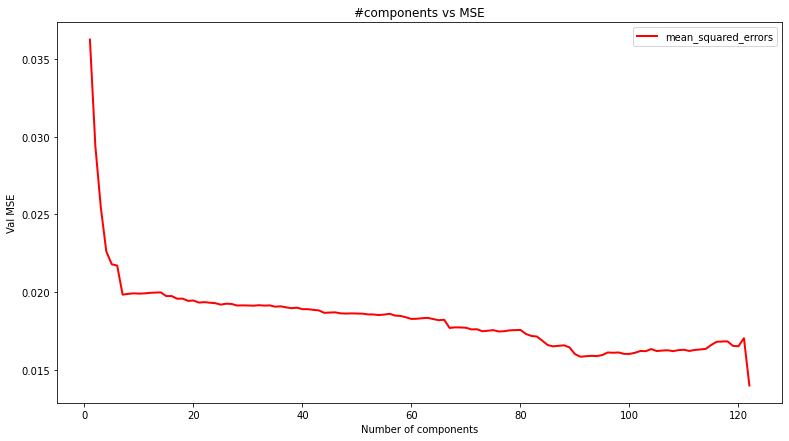

In [49]:
mse_by_m_components.plot(figsize=(13,7),lw=2,c='r')
plt.xlabel("Number of components")
plt.ylabel("Val MSE")
plt.title("#components vs MSE")
plt.show()

In [50]:
m_components = mse_by_m_components['mean_squared_errors'].argmin()
lin_reg = LinearRegression()
lin_reg.fit(pc_scores_train[:,0:m_components],ytrain)

LinearRegression()

In [51]:
print("MSE Test",mean_squared_error(y_true=ytest,y_pred=lin_reg.predict(pc_scores_test[:,0:m_components])))

MSE Test 0.014675768562641002


#### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L 1 -penalized regression at each node. Such a tree is called L 1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation

In [ ]:
# !pip install xgboost

In [54]:
xgbreg = XGBRegressor()

#Using Grid Search CV to find the best reg_alpha
grid_search_cv = GridSearchCV(xgbreg, param_grid={'n_estimators':np.arange(5,10,1),'reg_alpha': np.arange(0.01,10,0.01)},\
                              verbose=1, cv=5,scoring='neg_mean_absolute_error')
grid_search_cv.fit(Xtrain, ytrain)

Fitting 5 folds for each of 4995 candidates, totalling 24975 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])},
             scoring='neg_mean_absolute_error', verbose=1)

In [55]:
print("Best Parameters:",grid_search_cv.best_params_)

Best Parameters: {'n_estimators': 9, 'reg_alpha': 0.36000000000000004}


In [56]:
best_estimator = grid_search_cv.best_estimator_
print(mean_absolute_error(ytest,best_estimator.predict(Xtest)))

0.09483189158126681
